In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Defining UANLL Loss

<div>
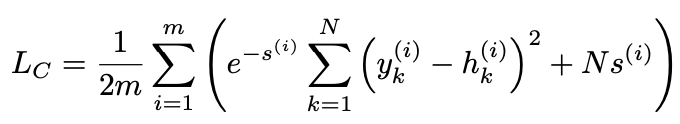
</div>

In [15]:
DEBUG_MODE = False

def debug(input):
    if DEBUG_MODE == True:
        print(input)
    else:
        pass

In [16]:
import torch
import torch.nn as nn

class UncertaintyAwareLoss(nn.Module):
    def __init__(self, smoothing=0.0):
        super(UncertaintyAwareLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, y_pred, y_true, s):
        """
        Compute the UANLL loss: .

        Args:
            y_pred (torch.Tensor): Predictions from the model (h_k^i).
                                   Shape: (batch_size, N).
            y_true (torch.Tensor): True labels (y_k^i).
                                   Shape: (batch_size, N).
            s (torch.Tensor): Uncertainty measure (s^i).
                              Shape: (batch_size,).

        Returns:
            torch.Tensor: Loss value.
        """
        m = y_pred.size(0)  # batch size
        N = y_pred.size(1)  # number of classes

        squared_diff = (y_pred - y_true) ** 2  # squared difference
        #variance_term = torch.exp(-s) * torch.sum(squared_diff, dim=1)  # variance term
        variance_term = torch.div(1, s ** 2) * torch.sum(squared_diff, dim=1)
        loss = torch.mean(variance_term + N * torch.log(s ** 2)) / 2  # compute loss
        
        debug('-----Loss Output-----')
        debug(f'm: {m}\nn: {N}')
        debug(f'Variance: {s}')
        debug(f'Squared Diff: {squared_diff[:3, :3]}')
        debug(f'Variance Term: {variance_term[:3]}')
        debug(f'Loss: {loss}')
        debug('-End of Loss Output---')

        # Apply label smoothing
        if self.smoothing > 0.0:
            smoothed_true = y_true * (1 - self.smoothing) + self.smoothing / N
            loss -= torch.sum(smoothed_true * torch.log(y_pred + 1e-9)) / m

        return loss

# Defining Model from DUQ paper adapted to use UANLL Loss

In [17]:
class Model_bilinear(nn.Module):
    def __init__(self, num_features, num_embeddings):
        super().__init__()
        
        self.gamma = 0.99
        self.sigma = 0.3
        
        embedding_size = 10
        
        self.fc1 = nn.Linear(2, num_features)
        self.fc2 = nn.Linear(num_features, num_features)
        self.fc3 = nn.Linear(num_features, num_features)
        
        self.W = nn.Parameter(torch.normal(torch.zeros(embedding_size, num_embeddings, num_features), 1))
        
        self.register_buffer('N', torch.ones(num_embeddings) * 20)
        self.register_buffer('m', torch.normal(torch.zeros(embedding_size, num_embeddings), 1))
        
        self.m = self.m * self.N.unsqueeze(0)

    
    def embed(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # i is batch, m is embedding_size, n is num_embeddings (classes)
        x = torch.einsum('ij,mnj->imn', x, self.W)
        
        return x
    
    def bilinear(self, z):
        embeddings = self.m / self.N.unsqueeze(0)

        diff = z - embeddings.unsqueeze(0)
        distances = (- diff**2).mean(1)  # Computing distances

        # Computing predictions h
        y_pred = distances.div(2 * self.sigma**2).exp()

        # Normalizing predictions to ensure they are in (0, 1)
        h = y_pred / y_pred.sum(dim=1, keepdim=True)

        # Computing uncertainty estimation s
        s = distances.min(dim=1).values  # Taking the minimum distance as uncertainty

        return h, s

    def forward(self, x):
        z = self.embed(x)
        h_pred, s_pred = self.bilinear(z)  # Getting predictions h and uncertainty s
        return z, h_pred, s_pred
    
    def update_embeddings(self, x, y):
        z = self.embed(x)

        # normalizing value per class, assumes y is one_hot encoded
        self.N = torch.max(self.gamma * self.N + (1 - self.gamma) * y.sum(0), torch.ones_like(self.N))

        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum('ijk,ik->jk', z, y)

        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum

# Defining Training Loop

In [18]:
np.random.seed(0)
torch.manual_seed(0)

l_gradient_penalty = 1.0

# Moons
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)

num_classes = 2
batch_size = 64

model = Model_bilinear(20, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [19]:
uncertainty_aware_loss = UncertaintyAwareLoss(smoothing=0.0)

In [20]:
import torch
import torch.nn.functional as F

def calc_gradient_penalty(x, y_pred):
    gradients = torch.autograd.grad(
            outputs=y_pred,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]


    gradients = gradients.flatten(start_dim=1)
    
    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()
    
    # One sided penalty - down
#     gradient_penalty = F.relu(grad_norm - 1).mean()

    return gradient_penalty

def step(engine, batch):
    model.train()
    optimizer.zero_grad()
    
    x, y = batch
    x.requires_grad_(True)
    
    z, h_pred, s_pred = model(x)
    
    debug(f'z:{z.shape}\nh_pred before softmax: {h_pred.shape}\ns_pred: {s_pred.shape}')
    
    softmax = nn.Softmax(dim=1)
    
    h_pred = softmax(h_pred)
    debug(f'h_pred:{h_pred[:3, :3]}')
    
    
    #loss1 =  F.binary_cross_entropy(h_pred, y)
    
    # Calculate gradient penalty
    gradient_penalty = l_gradient_penalty * calc_gradient_penalty(x, h_pred)
    debug(f'Gradient penalty: {gradient_penalty}')
    
    # Initialize the UncertaintyAwareLoss with the log variances
    uanll_loss = uncertainty_aware_loss(h_pred, y, s_pred)
    debug(f'UANNL Loss: {uanll_loss}')
    
    loss = gradient_penalty + uanll_loss
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.update_embeddings(x, y)
    
    return loss.item()

def eval_step(engine, batch):
    model.eval()

    x, y = batch

    x.requires_grad_(True)

    z, h_pred, s_pred = model(x)

    return {
        "y_pred": h_pred,
        "y_true": y,
        "s_pred": s_pred,
        "x": x,
        "z": z
    }


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False)

batch_size = 64

trainer = Engine(step)
evaluator = Engine(eval_step)

@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics


In [22]:
trainer.run(train_loader, max_epochs=30)

State:
	iteration: 690
	epoch: 30
	epoch_length: 23
	max_epochs: 30
	output: -0.24281203746795654
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

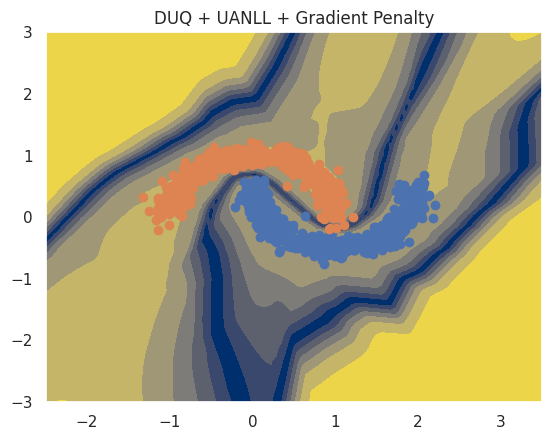

In [33]:
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(np.bool_)

with torch.no_grad():
    output = model(torch.from_numpy(X_grid).float())[1]
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])
plt.title('DUQ + UANLL + Gradient Penalty')
plt.show()